**Домашнее задание №5 (Математические основы машинного обучения)**

# ОПТИМИЗАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ

In [379]:
# импортируем библиотеки:

import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn   

from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn import preprocessing as prep  # общий модуль предварительной обработки scikit-learn
from sklearn import set_config # для доп настроек
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn
from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

from sklearn.decomposition import PCA # Метод главных компонент от мира scikit-learn

import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression # Логистичекая регрессия от scikit-learn
from sklearn.linear_model import Lasso # L1-регуляризация
from sklearn.linear_model import Ridge # L2-регуляризация

from sklearn.metrics import f1_score # f1-мера
from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn
from sklearn.metrics import mean_squared_error as MSE 

In [380]:
set_config(display="diagram") #чтобы была красивая визуализация

## Общие функции

In [381]:
def calculate_f1_score(model_pipe, X, y):
    """Расчет коэффициента f1.    
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    """
    y_model = model_pipe.predict(X)
    return f1_score(y, y_model)

In [382]:
def plot_w(w, b, features_names):
    DF_w = pd.DataFrame()
    DF_w['w'], DF_w['features_names']  = w, features_names
    DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(0.95)]

    plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
    plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

In [383]:
def plot_model_weights(X_train, 
                       y_train, 
                       y_train_predict, 
                       X_test, 
                       y_test_predict):
  
    plt.figure(figsize=(20,10))

    plt.plot(X_train[:,0], y_train_predict,
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(X_test[:,0], y_test_predict,
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(X_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')

    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=25)
    plt.ylabel('y',fontsize=25);
    plt.xticks(FontSize = 20)
    plt.yticks(FontSize = 20);

## Подключение файла

In [384]:
df = pd.read_csv('/content/drive/MyDrive/lectures/mf-ml/colab/dz/5/date/cars_moldova_clean-v2.csv', delimiter = ',')

In [385]:
df = df.drop(columns = ['Price_Ru'])

In [386]:
df

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price_euro,km_year,Dis_rating,Nalog_cof
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,17727.272727,medium,0.6
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,16875.000000,medium,0.6
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11000.000000,medium,0.6
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,12500.000000,medium,0.6
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,13636.363636,medium,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
32069,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,14666.666667,medium,0.6
32070,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,11250.000000,medium,0.6
32071,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,12714.285714,medium,0.6
32072,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,23125.000000,large,0.6


## Предварительная обработка ДФ, числовых-категориальных данных

In [387]:
data = df.drop(columns = ['Price_euro']) # в признаках нам не нужен 'Price'

cat_columns = []
num_columns = []

for column_name in data.columns:
    if (data[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))


target = df['Price_euro'] # поскольку это целевая метка

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Dis_rating'] 
 len =  6
numerical columns:	  ['Year', 'Distance', 'Engine_capacity', 'km_year', 'Nalog_cof'] 
 len =  5


In [388]:
cat_columns

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Dis_rating']

In [389]:
random_state = 42

In [390]:
X_train, X_val, y_train, y_val = train_test_split(data, target,
                                                  test_size = 0.2, random_state = random_state)

## Числовых данных 

In [391]:
#PF = PolynomialFeatures(degree=2, # степень - вторая, хватит уж
#                        include_bias=False, # если хотим добавить константу
#                        interaction_only=False # если не хотим x^2, y^2, а только x*y
#                        )

Исходя из анализа подбора гиперпараметров сеткой PCA = 4

In [392]:
#1) валидация данных от пропусков и ошибок
#2) Полиномы
#3) Стандартизация или нормализация
#4) PCA
numerical_pipe_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
#    ('poly_features', PF),
    ('scaler', MinMaxScaler()),
    ('PCA', PCA(n_components=5)),
])

In [393]:
numerical_pipe_pca

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('PCA', PCA(n_components=5))])

## Категориальных данных

In [394]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))
])

In [395]:
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse=False))])

# Трансформер колонок даныых

In [396]:
preprocessors_pca = ColumnTransformer(transformers=[
    ('num', numerical_pipe_pca, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

In [397]:
preprocessors_pca

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('PCA', PCA(n_components=5))]),
                                 ['Year', 'Distance', 'Engine_capacity',
                                  'km_year', 'Nalog_cof']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission', 'Dis_rating'])])

In [398]:
preprocessors_pca.fit(X_train);

In [399]:
# исходя из cетки:

pipe = Pipeline([
    ('preprocessors', preprocessors_pca),
    ('model', LinearRegression(fit_intercept=False))
])

In [400]:
pipe['preprocessors']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('PCA', PCA(n_components=5))]),
                                 ['Year', 'Distance', 'Engine_capacity',
                                  'km_year', 'Nalog_cof']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission', 'Dis_rating'])])

In [401]:
pipe['model']

LinearRegression(fit_intercept=False)

In [402]:
pipe 

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=5))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type', 'Transmission',
                                                   'Dis_rating'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [403]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=5))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type', 'Transmission',
                                                   'Dis_rating'])])),
                ('model', LinearRegression(fit_intercept=False))])

# Вывод:

Необходимо увеличить количество параметров в модели, но на данный момент Грид насчитал 5 компонентов и отсутсвие Б0 - лучшими гиперпараметрами для модели.

In [404]:
print(f'r2_val_Yp-Y: {r2_score(pipe.predict(X_val), y_val)}',
      f'\nr2_train_Yp-Y: {r2_score(pipe.predict(X_train), y_train)}',
      f'\nMSE: {MSE(pipe.predict(X_val), y_val)}')

r2_val_Yp-Y: 0.3755136524405964 
r2_train_Yp-Y: 0.43295609536751034 
MSE: 36363019.8604107


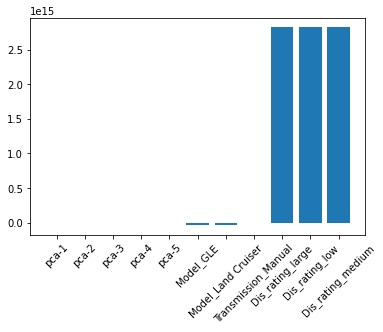

In [405]:
plot_w(pipe[1].coef_,
       pipe[1].intercept_,
       np.append(['pca-1','pca-2', 'pca-3','pca-4','pca-5'],
                 preprocessors_pca.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)))

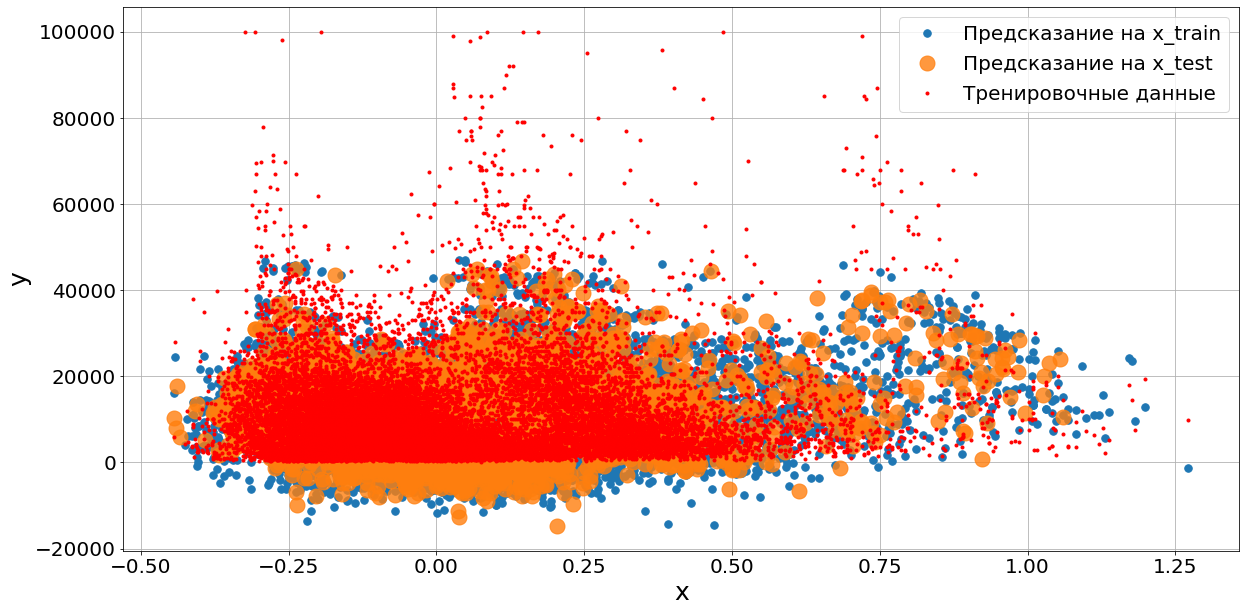

In [406]:
plot_model_weights(preprocessors_pca.transform(X_train), 
                    y_train, 
                    pipe.predict(X_train), 
                    preprocessors_pca.transform(X_val), 
                    pipe.predict(X_val)
                  )

# Вывод: 
Необходимо увеличить количество параметров в модели, но на данный момент Грид насчитал 5 компонентов и отсутсвие Б0 - лучшими гиперпараметрами для модели

# Преобразовываем в новый DateFrame 

Новые числовые столбцы

In [407]:
#num_poly_names = preprocessors_pca.transformers_[0][1]['poly_features'].get_feature_names_out(num_columns)
#num_poly_names

Новые категориальные столбцы

In [408]:
cat_ohe_names = preprocessors_pca.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)
cat_ohe_names

array(['Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo',
       'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford',
       'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti',
       'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover',
       'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes',
       'Make_Mini', 'Make_Mitsubishi', 'Make_Moskvich / Izh',
       'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche',
       'Make_Rare_Cheap', 'Make_Rare_Good', 'Make_Renault', 'Make_Rover',
       'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong',
       'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz',
       'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206',
       'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3',
       'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series',
       'Model_6', 'Model_626', 'Model_7 Series', 'Model_80',
     

Новый общий ДатаФрейм (PCA = 4)

In [409]:
train_data = preprocessors_pca.transform(X_train) # преобразуем данные
columns = np.append(['pca-1','pca-2', 'pca-3','pca-4','pca-5'], cat_ohe_names) # объединяем названия колонок
DF = pd.DataFrame(train_data, columns=columns,) #смотрим на датафрейм
DF

,pca-1,pca-2,pca-3,pca-4,pca-5,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,...,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual,Dis_rating_large,Dis_rating_low,Dis_rating_medium
0,-0.262443,0.239350,-0.409870,0.048246,0.167762,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.122293,0.020631,-0.157113,-0.003883,-0.001364,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.216946,0.105920,0.113365,0.014439,-0.014172,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.158743,0.230968,-0.175640,0.077519,0.019558,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.042207,-0.157372,0.002246,0.010305,-0.028600,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25654,0.007864,-0.130390,-0.123142,-0.058192,-0.014909,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25655,0.288479,0.052051,0.036031,0.020641,-0.019723,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
25656,0.046158,-0.231228,-0.015980,-0.043391,-0.032592,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
25657,0.070831,-0.228322,-0.010401,-0.078106,-0.029471,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Аналогично для валидационных данных

In [410]:
val_data = preprocessors_pca.transform(X_val)
pd.DataFrame(val_data, columns=columns,)

,pca-1,pca-2,pca-3,pca-4,pca-5,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,...,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual,Dis_rating_large,Dis_rating_low,Dis_rating_medium
0,0.417291,-0.042557,-0.254540,-0.029986,0.023256,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.128410,0.079756,0.055588,-0.071571,-0.013522,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.096345,-0.058428,-0.063870,0.011216,-0.024333,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.067045,-0.127163,-0.066857,0.027694,-0.029185,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.179243,0.215883,0.108884,0.023599,-0.006975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410,0.073120,-0.209453,-0.143868,-0.077644,-0.019613,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6411,-0.128828,-0.045132,0.036169,0.029493,-0.022894,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6412,0.014908,-0.154774,-0.040303,-0.059618,-0.024445,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6413,0.664156,0.148954,-0.080903,0.081159,-0.018554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Подбор гиперпараметров

In [411]:
# импортируем библиотеки:

from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
# альтернативно можно воспользоваться RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

а) Для логистической регрессии - сетка

In [412]:
pipe_gs = Pipeline([
    ('preprocessors', preprocessors_pca),
    ('model', LinearRegression())
])

In [413]:
param_grid = {
    # ВАЖНО используем "имена" которые есть у компонент Pipeline и разделяем их __ (две земли)
    # Поскольку PCA у нас "спрятан" то нужно пройти глубоко, идем с конца
    # ↓ pipe_gs  
    #               ↓preprocessors_pca 
    #                    ↓numerical_pipe_pca
    #                         ↓PCA
    "preprocessors__num__PCA__n_components": np.arange(1,6), # Варьируем количество главных компонент от 1 до 5 (количество числовых признаков)
    # ↓ pipe_gs  
    #       ↓ LogisticRegression
    "model__fit_intercept": [True, False], # аналог 10**np.linspace(-4,4,5) рассмотренного в блокноте про подбор гиперпараметров
}

In [414]:
Pipe_GS = GridSearchCV(estimator = pipe_gs, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler()),
                                                                                         ('PCA',
                                                                                          PCA(n_components=5))]),
                                                                         ['Year',
                                                                          'Distance',
                                                                          'Engine_capacity',
                                                                          'km_year',
                                                                          'Nalog_cof']),
                                                                        ('...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Make',
                                                                          'Model',
                                                                          'Style',
                                                                          'Fuel_type',
                                                                          'Transmission',
                                                                          'Dis_rating'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocessors__num__PCA__n_components': array([1, 2, 3, 4, 5])},
             verbose=2)

In [415]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=1; total time=   0.6s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=1; total time=   0.7s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=1; total time=   0.7s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=1; total time=   0.6s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=1; total time=   0.6s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=2; total time=   0.6s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=2; total time=   0.6s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=2; total time=   0.7s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=2; total time=   0.7s
[CV] END model__fit_intercept=True, preprocessors__num__PCA__n_components=2

In [416]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=5))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type', 'Transmission',
                                                   'Dis_rating'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [417]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe     

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__fit_intercept,param_preprocessors__num__PCA__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.602046,0.024665,0.037830,0.010943,True,1,"{'model__fit_intercept': True, 'preprocessors_...",0.517206,0.581330,0.539541,0.519831,0.470563,0.525694,0.035869,9
1,0.622053,0.042852,0.026264,0.005227,True,2,"{'model__fit_intercept': True, 'preprocessors_...",0.585390,0.640402,0.600122,0.581424,0.529470,0.587362,0.035684,7
2,0.649026,0.025642,0.024386,0.002562,True,3,"{'model__fit_intercept': True, 'preprocessors_...",0.628014,0.685285,0.659682,0.628690,0.577490,0.635832,0.036140,6
3,0.596846,0.016270,0.029117,0.003205,True,4,"{'model__fit_intercept': True, 'preprocessors_...",0.627732,0.689912,0.663478,0.632925,0.580904,0.638990,0.036689,4
4,0.798232,0.322268,0.037086,0.015469,True,5,"{'model__fit_intercept': True, 'preprocessors_...",0.629370,0.691362,0.665254,0.631995,0.580552,0.639707,0.037381,2
5,0.589590,0.029326,0.038706,0.012946,False,1,"{'model__fit_intercept': False, 'preprocessors...",0.517222,0.581303,0.539553,0.519818,0.470565,0.525692,0.035861,10
6,0.624915,0.019110,0.029687,0.004101,False,2,"{'model__fit_intercept': False, 'preprocessors...",0.585448,0.640251,0.600170,0.581428,0.529473,0.587354,0.035641,8
7,0.637464,0.033622,0.031894,0.008097,False,3,"{'model__fit_intercept': False, 'preprocessors...",0.628007,0.685392,0.659673,0.628956,0.577963,0.635998,0.036005,5
8,0.575302,0.020939,0.026513,0.004099,False,4,"{'model__fit_intercept': False, 'preprocessors...",0.628010,0.689913,0.663474,0.632942,0.581070,0.639082,0.036618,3
9,0.571777,0.020900,0.025122,0.002147,False,5,"{'model__fit_intercept': False, 'preprocessors...",0.629396,0.691365,0.665244,0.632427,0.580534,0.639793,0.037367,1


In [418]:
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__fit_intercept',
       'param_preprocessors__num__PCA__n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [419]:
DF_ = DF_Pipe[['param_model__fit_intercept', 'param_preprocessors__num__PCA__n_components', # берем только гиперпараметры,
             'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разбросс метрики на кросс-валидации
             'rank_test_score']]    # место
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__fit_intercept,param_preprocessors__num__PCA__n_components,mean_test_score,std_test_score,rank_test_score
9,False,5,0.639793,0.037367,1
4,True,5,0.639707,0.037381,2
8,False,4,0.639082,0.036618,3
3,True,4,0.638990,0.036689,4
7,False,3,0.635998,0.036005,5
2,True,3,0.635832,0.036140,6
1,True,2,0.587362,0.035684,7
6,False,2,0.587354,0.035641,8
0,True,1,0.525694,0.035869,9
5,False,1,0.525692,0.035861,10


Вывод был дан в лекции.

# ОПТИМИЗАЦИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

In [ ]:
# импортируем библиотеки:

import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn   

from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn

from sklearn import preprocessing as prep  # общий модуль предварительной обработки scikit-learn
from sklearn import set_config # для доп настроек

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.linear_model import LogisticRegression # Логистичекая регрессия от scikit-learn
from sklearn.metrics import f1_score # f1-мера

from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

from sklearn.decomposition import PCA # Метод главных компонент от мира scikit-learn

import matplotlib.pyplot as plt 

from sklearn.linear_model import Lasso # L1-регуляризация
from sklearn.linear_model import Ridge # L2-регуляризация

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

In [ ]:
set_config(display="diagram") #чтобы была красивая визуализация

Общие функции

In [ ]:
def calculate_f1_score(model_pipe, X, y):
    """Расчет коэффициента f1.    
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    """
    y_model = model_pipe.predict(X)
    return f1_score(y, y_model)

In [ ]:
def plot_w(w, b, features_names):
    DF_w = pd.DataFrame()
    DF_w['w'], DF_w['features_names']  = w, features_names
    DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(0.95)]

    plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
    plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/lectures/mf-ml/colab/dz/5/date/cars_moldova_clean-v2.csv', delimiter = ',') # подключаем файл

In [ ]:
df = df.drop(columns = ['Price_Ru'])

In [ ]:
df

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price_euro,km_year,Dis_rating,Nalog_cof
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,17727.272727,medium,0.6
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,16875.000000,medium,0.6
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11000.000000,medium,0.6
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,12500.000000,medium,0.6
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,13636.363636,medium,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
32069,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,14666.666667,medium,0.6
32070,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,11250.000000,medium,0.6
32071,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,12714.285714,medium,0.6
32072,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,23125.000000,large,0.6


# Предварительная обработка ДФ, числовых/категориальных данных

In [ ]:
data = df.drop(columns = ['Transmission']) # в признаках нам не нужен 'Transmission'

cat_columns = []
num_columns = []

for column_name in data.columns:
    if (data[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))


target = df['Transmission'] # поскольку это целевая метка

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Dis_rating'] 
 len =  5
numerical columns:	  ['Year', 'Distance', 'Engine_capacity', 'Price_euro', 'km_year', 'Nalog_cof'] 
 len =  6


In [ ]:
cat_columns

['Make', 'Model', 'Style', 'Fuel_type', 'Dis_rating']

In [ ]:
Label = prep.LabelEncoder()
Label.fit(target) # задаем столбец, который хотим преобразовать
Label.classes_ # в аттрибуте .classes_ хранится информация "какой класс как шифруется"

array(['Automatic', 'Manual'], dtype=object)

In [ ]:
Label_encoded = Label.transform(target) # преобразуем и сохраняем в новую переменную

In [ ]:
Label_encoded # здесь уже только 0 и 1

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
random_state = 42

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, Label_encoded,
                                                  test_size = 0.2, random_state = random_state)

Числовые данные

In [ ]:
#PF = PolynomialFeatures(degree=2, # степень - вторая, хватит уж
#                        include_bias=False, # если хотим добавить константу
#                        interaction_only=False # если не хотим x^2, y^2, а только x*y
#                        )

***Исходя из анализа подбора гиперпараметров сеткой PCA = 4***

In [ ]:
#1) валидация данных от пропусков и ошибок
#2) Полиномы
#3) Стандартизация или нормализация
#4) PCA
numerical_pipe_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
#    ('poly_features', PF),
    ('scaler', MinMaxScaler()),
    ('PCA', PCA(n_components=4)),
])

In [ ]:
numerical_pipe_pca

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('PCA', PCA(n_components=4))])

Категориальные данные

In [ ]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))
])

In [ ]:
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse=False))])

Трансформер колонок даныых

In [ ]:
preprocessors_pca = ColumnTransformer(transformers=[
    ('num', numerical_pipe_pca, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

In [ ]:
preprocessors_pca

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('PCA', PCA(n_components=4))]),
                                 ['Year', 'Distance', 'Engine_capacity',
                                  'Price_euro', 'km_year', 'Nalog_cof']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Dis_rating'])])

In [ ]:
preprocessors_pca.fit(X_train);

In [ ]:
pipe = Pipeline([
    ('preprocessors', preprocessors_pca),
    ('model', LogisticRegression(C=0.001, random_state=42))
])

In [ ]:
pipe['preprocessors']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('PCA', PCA(n_components=4))]),
                                 ['Year', 'Distance', 'Engine_capacity',
                                  'Price_euro', 'km_year', 'Nalog_cof']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Dis_rating'])])

In [ ]:
pipe['model']

LogisticRegression(C=0.001, random_state=42)

In [ ]:
pipe 

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=4))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity',
                                                   'Price_euro', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Dis_rating'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=4))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity',
                                                   'Price_euro', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Dis_rating'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

# Вывод:

In [ ]:
print(f"F1 на тренировочной выборке: {calculate_f1_score(pipe, X_train, y_train):.4f}")

print(f"F1 на валидационной выборке: {calculate_f1_score(pipe, X_val, y_val):.4f}")

F1 на тренировочной выборке: 0.8252
F1 на валидационной выборке: 0.8389


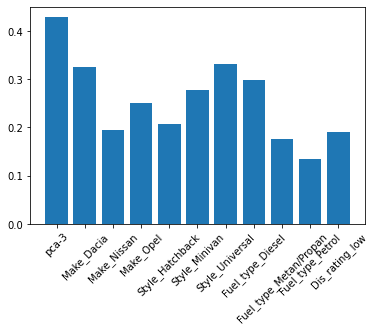

In [ ]:
plot_w(pipe[1].coef_[0],
       pipe[1].intercept_,
       np.append(['pca-1','pca-2', 'pca-3','pca-4'],
                 preprocessors_pca.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)))

# Вывод: 

С полиномами было лучше, чем с PCA, надо увеличивать количество параметров в модели. В сущности веса остались почти такими же как и в прошлых ДЗ, кроме нового - PCA-3.

# Преобразовываем в новый DateFrame 

Новые числовые столбцы

In [ ]:
#num_poly_names = preprocessors_pca.transformers_[0][1]['poly_features'].get_feature_names_out(num_columns)
#num_poly_names

Новые категориальные столбцы

In [ ]:
cat_ohe_names = preprocessors_pca.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)
cat_ohe_names

array(['Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo',
       'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford',
       'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti',
       'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover',
       'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes',
       'Make_Mini', 'Make_Mitsubishi', 'Make_Moskvich / Izh',
       'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche',
       'Make_Rare_Cheap', 'Make_Rare_Good', 'Make_Renault', 'Make_Rover',
       'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong',
       'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz',
       'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206',
       'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3',
       'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series',
       'Model_6', 'Model_626', 'Model_7 Series', 'Model_80',
     

## Новый общий ДатаФрейм (PCA = 4)

In [ ]:
train_data = preprocessors_pca.transform(X_train) # преобразуем данные
columns = np.append(['pca-1','pca-2', 'pca-3','pca-4'], cat_ohe_names) # объединяем названия колонок
DF = pd.DataFrame(train_data, columns=columns,) #смотрим на датафрейм
DF

,pca-1,pca-2,pca-3,pca-4,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,...,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Dis_rating_large,Dis_rating_low,Dis_rating_medium
0,-0.261840,0.146101,0.460289,-0.035036,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.130072,-0.017604,0.164340,-0.010516,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.205940,0.131993,-0.075038,-0.078222,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.165044,0.144326,0.246871,-0.104818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.058407,-0.157245,-0.033179,-0.014598,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25654,-0.010229,-0.159258,0.090926,0.052032,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25655,0.290875,0.021154,-0.008364,-0.051199,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25656,0.024227,-0.233159,-0.037916,0.045460,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
25657,0.048373,-0.235013,-0.039309,0.053157,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Аналогично для валидационных данных

In [ ]:
val_data = preprocessors_pca.transform(X_val)
pd.DataFrame(val_data, columns=columns,)

,pca-1,pca-2,pca-3,pca-4,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,...,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Dis_rating_large,Dis_rating_low,Dis_rating_medium
0,0.397094,-0.152983,0.254877,0.016106,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.119516,0.097381,-0.033603,0.011773,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.107915,-0.077771,0.058074,-0.031313,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.084101,-0.144140,0.042307,-0.023531,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.204126,0.223270,-0.054743,-0.034687,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410,0.044487,-0.255682,0.100406,0.048826,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6411,-0.131560,-0.026437,-0.045713,-0.023717,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6412,-0.002860,-0.168692,0.008600,0.031930,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6413,0.665711,0.041433,0.144170,-0.109718,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Подбор гиперпараметров

In [ ]:
# импортируем библиотеки: 
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
# альтернативно можно воспользоваться RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации
import seaborn as sns # чтобы подкрасить таблички

а) Для Логистической регрессии - сетка

In [ ]:
pipe_gs = Pipeline([
    ('preprocessors', preprocessors_pca),
    ('model', LogisticRegression(random_state=42,
                                 max_iter = 10000,
                                 solver = 'liblinear'))
])

In [ ]:
param_grid = {
    # ВАЖНО используем "имена" которые есть у компонент Pipeline и разделяем их __ (две земли)
    # Поскольку PCA у нас "спрятан" то нужно пройти глубоко, идем с конца
    # ↓ pipe_gs  
    #               ↓preprocessors_pca 
    #                    ↓numerical_pipe_pca
    #                         ↓PCA
    "preprocessors__num__PCA__n_components": np.arange(1,6), # Варьируем количество главных компонент от 1 до 5 (количество числовых признаков)
    # ↓ pipe_gs  
    #       ↓ LogisticRegression
    "model__C": np.logspace(-4, 4, 5), # аналог 10**np.linspace(-4,4,5) рассмотренного в блокноте про подбор гиперпараметров
}

In [ ]:
Pipe_GS = GridSearchCV(estimator = pipe_gs, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler()),
                                                                                         ('PCA',
                                                                                          PCA(n_components=4))]),
                                                                         ['Year',
                                                                          'Distance',
                                                                          'Engine_capacity',
                                                                          'Price_euro',
                                                                          'km_year',
                                                                          'Na...
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Make',
                                                                          'Model',
                                                                          'Style',
                                                                          'Fuel_type',
                                                                          'Dis_rating'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'preprocessors__num__PCA__n_components': array([1, 2, 3, 4, 5])},
             verbose=2)

In [ ]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.3s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.3s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.3s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.3s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.4s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=3; total time=

In [ ]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=4))]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity',
                                                   'Price_euro', 'km_year',
                                                   'Nalog_cof']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Dis_rating'])])),
                ('model',
                 LogisticRegression(C=10000.0, max_iter=10000, random_state=42,
                                    solver='liblinear'))])

In [ ]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe     

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_preprocessors__num__PCA__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.333188,0.022772,0.031031,0.007232,0.0001,1,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.647311,0.639517,0.666407,0.651988,0.657833,0.652611,0.009138,25
1,0.326802,0.020439,0.022207,0.001908,0.0001,2,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.681995,0.666017,0.685113,0.668745,0.680436,0.676461,0.007614,24
2,0.314553,0.019115,0.019255,0.000839,0.0001,3,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.692518,0.668745,0.691738,0.675370,0.685113,0.682697,0.009299,23
3,0.325689,0.007876,0.018436,0.000557,0.0001,4,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.692518,0.669135,0.691738,0.675370,0.685113,0.682775,0.009183,22
4,0.258940,0.006580,0.019250,0.001483,0.0001,5,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.693297,0.669135,0.692518,0.675760,0.685113,0.683164,0.009440,21
5,0.327546,0.016885,0.024284,0.000847,0.01,1,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.777085,0.776695,0.779813,0.783320,0.780982,0.779579,0.002472,20
6,0.383459,0.084797,0.031316,0.010988,0.01,2,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.826189,0.822681,0.818005,0.824240,0.826578,0.823539,0.003102,16
7,0.542113,0.039028,0.033102,0.006278,0.01,3,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.832814,0.833203,0.830865,0.832034,0.834762,0.832736,0.001290,13
8,0.567654,0.017298,0.035742,0.003847,0.01,4,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.832814,0.831645,0.831645,0.830475,0.834373,0.832190,0.001318,14
9,0.408339,0.081011,0.032391,0.011571,0.01,5,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.831645,0.831255,0.830086,0.830475,0.833983,0.831489,0.001363,15


In [ ]:
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'param_preprocessors__num__PCA__n_components',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
DF_ = DF_Pipe[['param_model__C', 'param_preprocessors__num__PCA__n_components', # берем только гиперпараметры,
             'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разбросс метрики на кросс-валидации
             'rank_test_score']]    # место
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__C,param_preprocessors__num__PCA__n_components,mean_test_score,std_test_score,rank_test_score
23,10000.000000,4,0.854248,0.002338,1
18,100.000000,4,0.854170,0.002330,2
24,10000.000000,5,0.853390,0.002432,3
19,100.000000,5,0.853390,0.002407,3
13,1.000000,4,0.852611,0.002760,5
14,1.000000,5,0.852377,0.003013,6
12,1.000000,3,0.846376,0.003283,7
17,100.000000,3,0.846220,0.002569,8
22,10000.000000,3,0.846064,0.002452,9
11,1.000000,2,0.838581,0.003013,10


Вывод был дан в лекции.